# find ROIs
hand-picked regions of interest based on the figure

![selected ROIs](./data/ROIs-annotated.png)

In [23]:
# setup brain plot
from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
import nibabel
from surfplot import Plot

fname = '/Users/qasem/PycharmProjects/gradients-rl-task/data/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii'
l_hemi, r_hemi = load_conte69()
vertices = nibabel.load(fname).get_fdata()[0]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [24]:
import pandas as pd

In [25]:
region_names = pd.read_csv('data/regions_sorted.csv')['region']

In [26]:
region_names[region_names.str.startswith('7Networks_LH_DorsAttn')]
data = pd.Series(region_names).str.startswith('7Networks_LH_DorsAttn_FEF_5')
# data = pd.Series(region_names)==('7Networks_LH_Default_PFC_4')
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=False, cmap='bwr')
# _ = p.build()

In [27]:
seeds = ['7Networks_LH_Default_PFC_19', '7Networks_RH_Default_PFCdPFCm_14', '7Networks_LH_Vis_33',
         '7Networks_RH_Default_PFCv_6', '7Networks_RH_Default_PFCdPFCm_15', '7Networks_LH_SomMot_57',
         '7Networks_RH_Limbic_TempPole_1', '7Networks_LH_Limbic_TempPole_9', '7Networks_RH_Vis_45',
         '7Networks_LH_Default_Temp_15', '7Networks_LH_Default_PFC_31', '7Networks_LH_Default_PFC_4',
         '7Networks_LH_DorsAttn_FEF_5']

let's take one as a sample seed ROI

# calculate correlation for seeds
for a seed ROI, calculate connectivity during epochs

In [47]:
EPOCHS = ['baseline', 'early', 'late']

In [48]:
# the list of subjects, removed erroneous ones
subjects = pd.read_csv('data/subjects.csv')
S = subjects.int_id

we are ignoring 'rest' epoch. all calculation on these subjects.

In [49]:
from scipy.stats import pearsonr
from tqdm import tqdm
tqdm.pandas()

In [50]:
# in data/ts/ we don't have cerebellum regions included. only 1012 regions.
def timeseries(subject, epoch): return pd.read_csv('data/ts/ts_'+str(subject)+'_'+epoch+'.csv')

In [56]:
list0 = []
for seed in tqdm(seeds):
    list1 = []
    for e in EPOCHS:
        list2 = []
        for subj in S:
            ts = timeseries(subj, e)
            seed_ts = ts[seed]
            # we neglect pvalue of whether r is significant
            r = [pearsonr(seed_ts, ts[idx])[0] for idx in ts]   # pearsonr()[0] is rvalue
            r = pd.DataFrame({'r': r}, index=ts.columns)
            r.rename_axis('region', inplace=True)
            r = pd.concat([r], keys=[subj], names=['subject'])
            list2.append(r)
        r = pd.concat(list2, 0)
        r = pd.concat([r], keys=[e], names=['epoch'])   # adds epoch as lower level index
        list1.append(r)

    dfr = pd.concat(list1, 0)
    dfr = pd.concat([dfr], keys=[seed], names=['seed_region'])
    list0.append(dfr)

dfr = pd.concat(list0, 0)

  0%|          | 0/13 [00:00<?, ?it/s]/var/folders/2q/y6tqndfj1yqfc7hcdp99tz_00000gn/T/ipykernel_45689/3137965780.py:15: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  r = pd.concat(list2, 0)
/var/folders/2q/y6tqndfj1yqfc7hcdp99tz_00000gn/T/ipykernel_45689/3137965780.py:15: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  r = pd.concat(list2, 0)
/var/folders/2q/y6tqndfj1yqfc7hcdp99tz_00000gn/T/ipykernel_45689/3137965780.py:15: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  r = pd.concat(list2, 0)
/var/folders/2q/y6tqndfj1yqfc7hcdp99tz_00000gn/T/ipykernel_45689/3137965780.py:19: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  dfr = pd.concat(list1, 0)
  8%|▊         | 1/13 [00:17<03:24, 

In [57]:
dfr

r
seed_region                 epoch    subject region                      
7Networks_LH_Default_PFC_19 baseline 1       7Networks_LH_Vis_1  0.127065
                                             7Networks_LH_Vis_2 -0.112173
                                             7Networks_LH_Vis_3  0.350969
                                             7Networks_LH_Vis_4  0.098825
                                             7Networks_LH_Vis_5  0.207375
...                                                                   ...
7Networks_LH_DorsAttn_FEF_5 late     46      Right Putamen       0.085640
                                             Right Pallidum     -0.022289
                                             Right Hippocampus   0.051076
                                             Right Amygdala      0.070943
                                             Right Accumbens    -0.084563

[1420848 rows x 1 columns]

# average over subjects
average seed connectivity over all subjects during each epoch.

In [58]:
dfr_mean = dfr.groupby(level=[0, 1, 3]).mean()
dfr_mean

r
seed_region                 epoch    region                            
7Networks_LH_Default_PFC_19 baseline 7Networks_LH_Cont_Cing_1  0.055564
                                     7Networks_LH_Cont_Cing_2 -0.045475
                                     7Networks_LH_Cont_Cing_3 -0.076467
                                     7Networks_LH_Cont_Cing_4 -0.031488
                                     7Networks_LH_Cont_Cing_5  0.094507
...                                                                 ...
7Networks_RH_Vis_45         late     Right Caudate             0.044653
                                     Right Hippocampus         0.033308
                                     Right Pallidum            0.001949
                                     Right Putamen            -0.000086
                                     Right Thalamus            0.099872

[39468 rows x 1 columns]

plot mean connectivity of one seed during one epoch

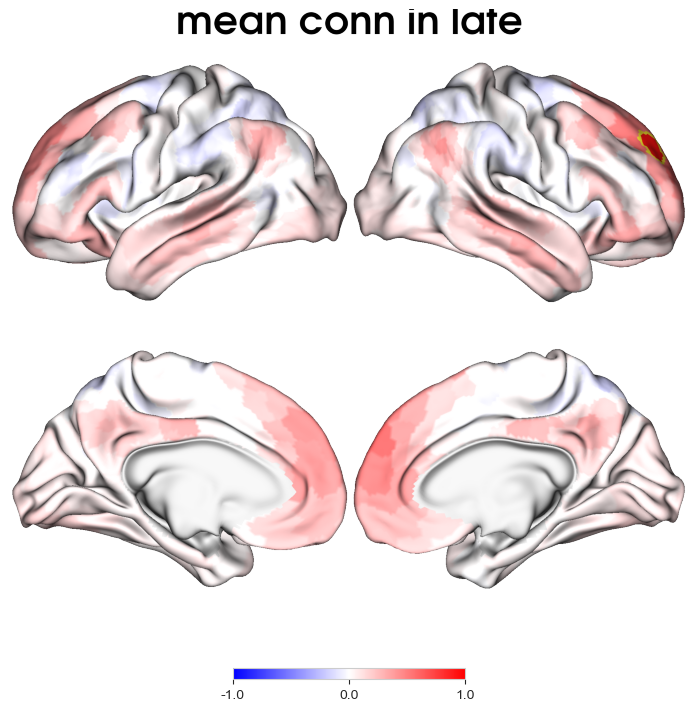

In [59]:
seed = seeds[1]
e = 'late'

data = dfr_mean.loc[seed, e]
data = data.loc[pd.Series(region_names)]['r']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 800),
         label_text={'top': ['mean conn in '+e]})
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-1, 1))
# seed region outlined
data = map_to_labels(pd.Series(region_names)==seed, vertices, mask=(vertices != 0))
p.add_layer(data, cbar=False, as_outline=True)
_ = p.build()

# shift in seed connectivity
using pairwise t-tests between epochs, we can calculate statistical diff for seed region-region link.

In [60]:
import pingouin as pg

dfp = dfr.reset_index([1,2]).groupby(level=[0,1]).progress_apply(pg.pairwise_tests, dv='r', between='epoch',
                                            subject='subject', padjust='fdr_bh')
dfp.reset_index(level=2, inplace=True)
dfp = dfp.set_index([dfp.index, 'A', 'B']).reorder_levels([0, 2, 3, 1])

  1%|          | 66/13156 [00:00<02:36, 83.52it/s]/Users/qasem/opt/anaconda3/envs/gradient-notebooks/lib/python3.8/site-packages/pingouin/parametric.py:261: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tval, pval = ttest_ind(x, y, equal_var=True, alternative=alternative)
/Users/qasem/opt/anaconda3/envs/gradient-notebooks/lib/python3.8/site-packages/pingouin/parametric.py:261: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tval, pval = ttest_ind(x, y, equal_var=True, alternative=alternative)
/Users/qasem/opt/anaconda3/envs/gradient-notebooks/lib/python3.8/site-packages/pingouin/parametric.py:261: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical.

In [61]:
dfp[['T', 'p-unc', 'p-corr']].head()

T  \
seed_region                 A        B     region                               
7Networks_LH_Default_PFC_19 baseline early 7Networks_LH_Cont_Cing_1 -1.132940   
                                     late  7Networks_LH_Cont_Cing_1 -0.464867   
                            early    late  7Networks_LH_Cont_Cing_1  0.798416   
                            baseline early 7Networks_LH_Cont_Cing_2 -1.874707   
                                     late  7Networks_LH_Cont_Cing_2  0.002361   

                                                                        p-unc  \
seed_region                 A        B     region                               
7Networks_LH_Default_PFC_19 baseline early 7Networks_LH_Cont_Cing_1  0.261105   
                                     late  7Networks_LH_Cont_Cing_1  0.643469   
                            early    late  7Networks_LH_Cont_Cing_1  0.427330   
                            baseline early 7Networks_LH_Cont_Cing_2  0.065005   
                                     late  7Networks_LH_Cont_Cing_2  0.998123   

                                                                       p-corr  
seed_region                 A        B     region                              
7Networks_LH_Default_PFC_19 baseline early 7Networks_LH_Cont_Cing_1  0.640995  
                                     late  7Networks_LH_Cont_Cing_1  0.643469  
                            early    late  7Networks_LH_Cont_Cing_1  0.640995  
                            baseline early 7Networks_LH_Cont_Cing_2  0.110151  
                                     late  7Networks_LH_Cont_Cing_2  0.998123

## baseline to early
this is how connectivity (pearson corr coef) shift for one seed region outlined in yellow.

for example, seed region conn shift; baseline to early t-tests; masked with corrected p value

In [62]:
def plot_seed_shift(seed_region, pair, masked=False, save=False):
    assert len(pair) == 2 and pair[0] in EPOCHS and pair[1] in EPOCHS

    idx = (seed_region, *pair)
    data = dfp.loc[idx] # connectivity shift for the seed region
    if masked:  data = data.apply(lambda row: row['T'] if row['p-corr'] < 0.05 else None, axis=1)
    else:   data = data['T']
    data = data.loc[pd.Series(region_names)]
    data = map_to_labels(data, vertices, mask=(vertices != 0))

    p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
    p.add_layer(data, cbar=True, cmap='bwr', color_range=(-4, 4))
    data = map_to_labels(pd.Series(region_names)==seed_region, vertices, mask=(vertices != 0))
    p.add_layer(data, cbar=False, as_outline=True)  # seed region outlined
    fig = p.build()
    masked = 'masked' if masked else 'notMasked'
    if save:    fig.savefig('plots/seed/' + seed_region[10:] + '__' + pair[0]+'2'+pair[1] + '__' + masked + '.png')

/var/folders/2q/y6tqndfj1yqfc7hcdp99tz_00000gn/T/ipykernel_45689/2608177470.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = dfp.loc[idx] # connectivity shift for the seed region


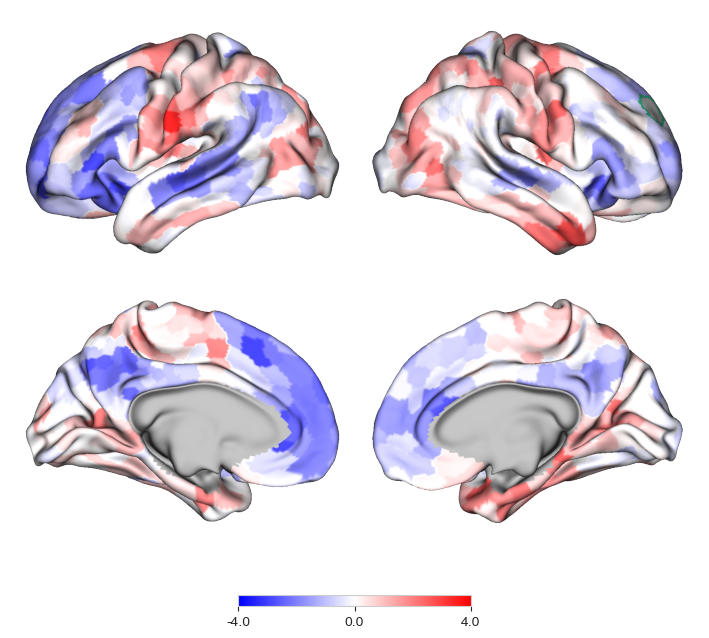

In [63]:
plot_seed_shift(seeds[1], ('baseline', 'early'), False)

In [67]:
# [plot_seed_shift(seed, pair, masked, save=True)
#  for seed in seeds
#  for pair in [('baseline', 'early'), ('early', 'late')]
#  for masked in [True, False]]